In [1]:
#This section links the notebook to the project root directory
import sys,os

nb_path = os.path.abspath('')
print("Current Path:", nb_path)

#get root working directory, link to notebook
PROJ_ROOT = os.path.abspath(os.path.join(nb_path,'..','..'))
print("Project Root:", PROJ_ROOT)
if PROJ_ROOT not in sys.path:
    sys.path.insert(0,PROJ_ROOT)

Current Path: /Users/saiganesh/Documents/MachineLearning/ECS171/project/project/models/mlp
Project Root: /Users/saiganesh/Documents/MachineLearning/ECS171/project/project


In [2]:
#Getting data, including preprocessing if necessary
from data_preprocess import preprocess

#get directory, and X.npy and y.npy
raw_dir_training = os.path.join(PROJ_ROOT, "..", "archive", "seg_train", "seg_train")
raw_dir_test = os.path.join(PROJ_ROOT,"..", "archive","seg_test","seg_test")
Xtrain_path,ytrain_path = 'Xtrain.npy','ytrain.npy'
Xtest_path,ytest_path = 'Xtest.npy','ytest.npy'

#check if npy training files exist
#if files do not exist, they will be created
##NOTE: doing so will use ~4.5GB of data, so please make sure they are
## in the correct directory so they are not reproduced.
print("Checking if training files exist...")
if not os.path.exists(Xtrain_path) or not os.path.exists(ytrain_path):
    print("Not found, now preprocessing training imgs...")
    preprocess(
        input_dir=raw_dir_training,
        target_size=(150,150),
        out_X="Xtrain.npy",
        out_y="ytrain.npy"
    )
    print("Finished preprocessing training! (Finished files may be in root. Please move to mlp folder.)")
else:
     print("Training files found!")

#check if npy test files exist
print("Checking if test files exist...")
if not os.path.exists(Xtest_path) or not os.path.exists(ytest_path):
    print("Not found, now preprocessing test imgs...")
    preprocess(
        input_dir=raw_dir_test,
        target_size=(150,150),
        out_X="Xtest.npy",
        out_y="ytest.npy"
    )
    print("Finished preprocessing test! (Finished files may be in root. Please move to mlp folder.)")
else:
    print("Test files found!")

Checking if training files exist...
Training files found!
Checking if test files exist...
Test files found!


In [3]:
#The interesting stuff, making the model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Load datasets from folder and print their shape
Xtrain,ytrain = np.load(Xtrain_path), np.load(ytrain_path)
print("X shape:", Xtrain.shape, "y shape:", ytrain.shape)

#Defining the function for the modelab
#making the MLP, using ReLU then softmax
def make_mlp(num_hidden=2,num_neurons=256,lr=0.001,dropout_rate=0.2):
    print("Making model")
    model = Sequential()

    #Input Layer
    model.add(Dense(num_neurons, activation='relu',input_shape=(67500,)))
    model.add(Dropout(dropout_rate))

    #Hidden layers, number of neurons decrease by half each layer
    for i in range(num_hidden):
        num_neurons = (num_neurons // 2)
        model.add(Dense(num_neurons, activation='relu')) #relu activation
        model.add(Dropout(dropout_rate))
    
    #Final output layer, with y outputs. softmax activator.
    model.add(Dense(len(np.unique(ytrain)), activation='softmax')) #output layer, using features from y, softmax for multiple classes

    #compile the model and get summary
    #Adam is used as optimizer for cleaner tuning
    #Loss is measured as sparse_categorical_crossentropy since data is not one hot encoded
    #And with multiple classes
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

testModel = make_mlp()
testModel.summary()

X shape: (14034, 67500) y shape: (14034,)
Making model


/Users/saiganesh/Documents/MachineLearning/ECS171/project/project/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-25 13:08:41.347181: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-05-25 13:08:41.347322: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-25 13:08:41.347336: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-25 13:08:41.347357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-25 13:08:41.347368: I tensorflow/core/common_runtime/pluggabl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,321,798 (66.08 MB)

 Trainable params: 17,321,798 (66.08 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#Here the model is tested with a smaller data set and tuned accordingly.
#Tuning had to be done by hand, as using GridSearchCV resulted in extremely long
#processing time and memory usage.
#Tuning by hand, with verbose on, allows for trackable progress.
#First, we halve our data to speed up tuning time

#Making smaller sample size
sample_size=int(Xtrain.shape[0]/2)
X_tune,y_tune = Xtrain[:sample_size],ytrain[:sample_size]

#Getting test data
Xtest, ytest = np.load(Xtest_path),np.load(ytest_path)
test_sample_size = int(Xtest.shape[0]/2)
X_tune_test,y_tune_test = Xtest[:test_sample_size],ytest[:test_sample_size]

print("X shape:",X_tune.shape,"y shape:",y_tune.shape)
print("X test shape:",X_tune_test.shape,"y test shape:",y_tune_test.shape)


X shape: (7017, 67500) y shape: (7017,)
X test shape: (1500, 67500) y test shape: (1500,)


In [5]:
#Training model_1
#Model 1 is baseline, no changes made.
model_1 = make_mlp() #No changes
print("Fitting model_1...")
hist_model_1=model_1.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_1...
Epoch 1/10


2025-05-25 13:08:44.354408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3496 - loss: 312.4339 - val_accuracy: 0.6580 - val_loss: 91.8152
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5058 - loss: 255.3278 - val_accuracy: 0.6653 - val_loss: 81.4105
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5500 - loss: 176.9734 - val_accuracy: 0.6787 - val_loss: 56.7998
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5532 - loss: 114.7957 - val_accuracy: 0.5920 - val_loss: 51.8645
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5662 - loss: 59.8467 - val_accuracy: 0.6940 - val_loss: 16.9767
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5522 - loss: 28.8237 - val_accuracy: 0.7013 - val_loss: 14.6464
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5590 - loss: 16.3589 - val_accuracy: 0.6280 - val_loss: 7.4933
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5475 - loss: 11.6998 - v

In [6]:
#Training model_2
#A dropout rate of 0.1 is used
model_2 = make_mlp(dropout_rate=0.1)
print("Fitting model_2...")
hist_model_2= model_2.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_2...
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.0130 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - 

In [7]:
#Training model_3
#A learning rate of 0.0001 is used
model_3 = make_mlp(lr=0.0001)
print("Fitting model_3...")
hist_model_3 = model_3.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_3...
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3526 - loss: 21.5929 - val_accuracy: 0.5520 - val_loss: 7.5867
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4215 - loss: 30.3997 - val_accuracy: 0.6507 - val_loss: 6.6418
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5072 - loss: 22.3081 - val_accuracy: 0.6780 - val_loss: 6.9920
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5349 - loss: 20.8554 - val_accuracy: 0.6947 - val_loss: 7.3861
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5448 - loss: 21.7553 - val_accuracy: 0.6993 - val_loss: 8.3076
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5416 - loss: 23.7833 - val_accuracy: 0.6947 - val_loss: 8.3686
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5517 - loss: 21.2359 - val_accuracy: 0.7100 - val_loss: 7.6323
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - acc

In [8]:
#Combining model 2 and 3
#Uses a dropout rate of 0.1 and a learning rate of 0.0001
model_4 = make_mlp(dropout_rate=0.1,lr=0.0001)
print("Fitting model_4...")
hist_model_4=model_4.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_4...
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3738 - loss: 15.0158 - val_accuracy: 0.5793 - val_loss: 5.0607
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4202 - loss: 21.0756 - val_accuracy: 0.6367 - val_loss: 5.9939
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4934 - loss: 21.7419 - val_accuracy: 0.6853 - val_loss: 7.3901
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5287 - loss: 21.6565 - val_accuracy: 0.6733 - val_loss: 8.1722
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5722 - loss: 18.5592 - val_accuracy: 0.7107 - val_loss: 7.2795
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5966 - loss: 17.8455 - val_accuracy: 0.6800 - val_loss: 8.0435
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5892 - loss: 16.7162 - val_accuracy: 0.7300 - val_loss: 6.4980
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - acc

Model Loss Visualization


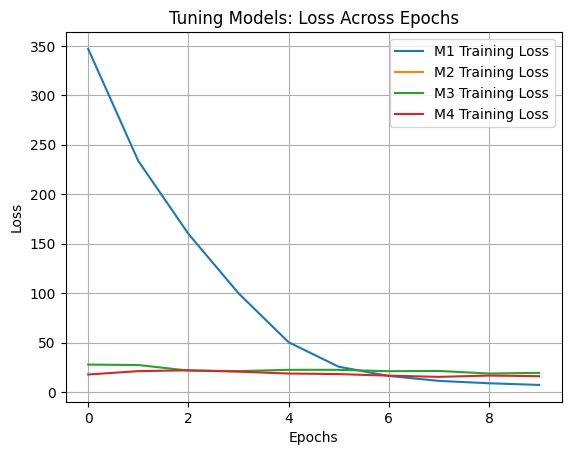

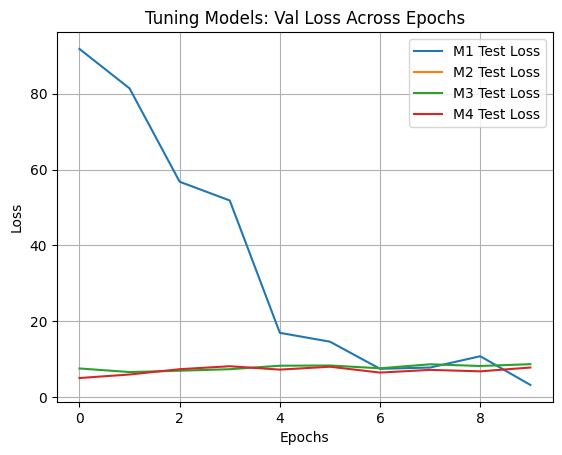

Model with consistently lower loss is model_4


In [9]:
import matplotlib.pyplot as plt

print("Model Loss Visualization")
plt.plot(hist_model_1.history['loss'], label='M1 Training Loss')
plt.plot(hist_model_2.history['loss'], label='M2 Training Loss')
plt.plot(hist_model_3.history['loss'], label='M3 Training Loss')
plt.plot(hist_model_4.history['loss'], label='M4 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_loss'],label='M1 Test Loss')
plt.plot(hist_model_2.history['val_loss'],label='M2 Test Loss')
plt.plot(hist_model_3.history['val_loss'],label='M3 Test Loss')
plt.plot(hist_model_4.history['val_loss'],label='M4 Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with consistently lower loss is model_4")

Model Accuracy Visualization


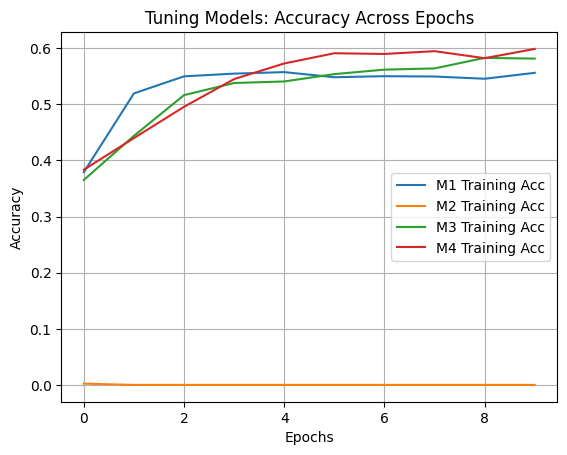

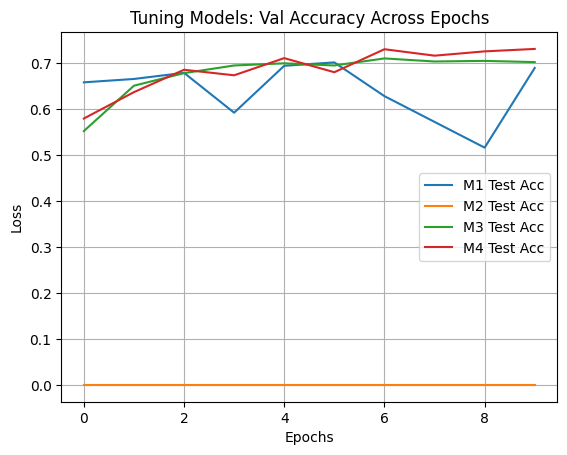

Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.


In [10]:
print("Model Accuracy Visualization")
plt.plot(hist_model_1.history['accuracy'], label='M1 Training Acc')
plt.plot(hist_model_2.history['accuracy'], label='M2 Training Acc')
plt.plot(hist_model_3.history['accuracy'], label='M3 Training Acc')
plt.plot(hist_model_4.history['accuracy'], label='M4 Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Tuning Models: Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_accuracy'],label='M1 Test Acc')
plt.plot(hist_model_2.history['val_accuracy'],label='M2 Test Acc')
plt.plot(hist_model_3.history['val_accuracy'],label='M3 Test Acc')
plt.plot(hist_model_4.history['val_accuracy'],label='M4 Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.")

In [11]:
#Training model_5
#Epoch size of 15 and batch size of 25
final_model = make_mlp(dropout_rate=0.1,lr=0.0001)
print("Fitting final model...")
hist_final_model= final_model.fit(Xtrain,ytrain,epochs=15,batch_size=25,validation_data=(Xtest,ytest)) #Final model is trained with more epochs and lower batch_size to allow more time for convergence, and lower memory load

Making model
Fitting final model...
Epoch 1/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.1980 - loss: 26.9002 - val_accuracy: 0.2940 - val_loss: 9.2593
Epoch 2/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.2480 - loss: 34.4814 - val_accuracy: 0.4607 - val_loss: 9.6346
Epoch 3/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.2987 - loss: 37.6428 - val_accuracy: 0.4587 - val_loss: 13.8637
Epoch 4/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.3237 - loss: 39.1402 - val_accuracy: 0.4840 - val_loss: 11.7065
Epoch 5/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.3494 - loss: 35.0997 - val_accuracy: 0.4877 - val_loss: 11.1293
Epoch 6/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.3606 - loss: 32.0801 - val_accuracy: 0.4917 - val_loss: 11.8124
Epoch 7/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.3515 - loss: 31.4434 - val_accuracy: 0.4733 - val_loss: 12.2604
Epoch 8/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 25

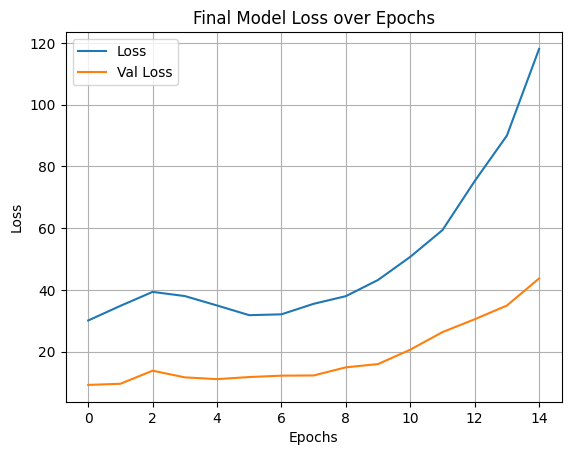

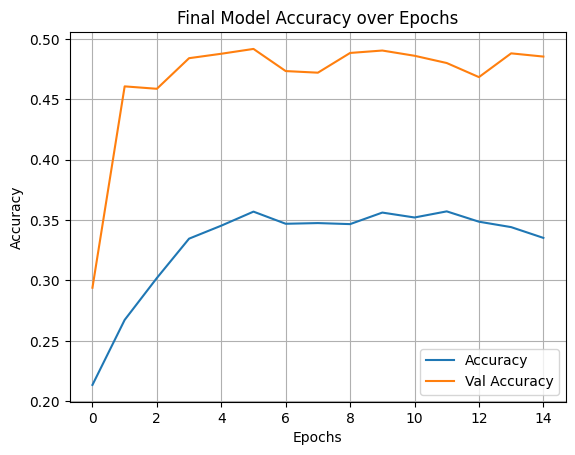

In [12]:
#Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Plotting loss and validation loss
plt.plot(hist_final_model.history['loss'], label='Loss')
plt.plot(hist_final_model.history['val_loss'],label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Final Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

#Plotting accuracy and validation accuracy
plt.plot(hist_final_model.history['accuracy'], label='Accuracy')
plt.plot(hist_final_model.history['val_accuracy'],label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Final Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


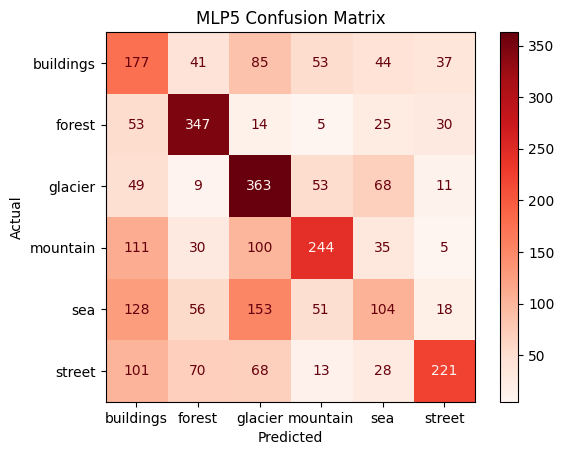

Prediction Shape: (3000,)
Test Shape: (3000,)
Num Samples in Matrix: 3000

Classification Report:
              precision    recall  f1-score   support

   buildings       0.29      0.41      0.34       437
      forest       0.63      0.73      0.68       474
     glacier       0.46      0.66      0.54       553
    mountain       0.58      0.46      0.52       525
         sea       0.34      0.20      0.26       510
      street       0.69      0.44      0.54       501

    accuracy                           0.49      3000
   macro avg       0.50      0.48      0.48      3000
weighted avg       0.50      0.49      0.48      3000

Total Accuracy: 0.48533333333333334


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# 1) Get your predictions
y_pred_prob     = final_model.predict(Xtest)
y_pred_classes  = np.argmax(y_pred_prob, axis=1)

# 2) Rebuild your class list, skipping dot-files like .DS_Store
classes = sorted(
    d for d in os.listdir(raw_dir_test)
    if not d.startswith('.') and os.path.isdir(os.path.join(raw_dir_test, d))
)
print("Classes:", classes)

# 3) Compute & plot confusion matrix
cm = confusion_matrix(ytest, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(cmap='Reds')
plt.title("MLP5 Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4) Sanity checks
print("Prediction Shape:", y_pred_classes.shape)
print("Test Shape:",       ytest.shape)
print("Num Samples in Matrix:", cm.sum())

# 5) Classification report & overall accuracy
print("\nClassification Report:")
print(classification_report(ytest, y_pred_classes,
                            target_names=classes))
print("Total Accuracy:", accuracy_score(ytest, y_pred_classes))

In [14]:
# after your final fit(...)
final_model.save("best_mlp.h5")